In [18]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.special import erf
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.preprocessing import MinMaxScaler


class knn_distinguish():
    def __init__(self, data, data_origin, predicted_class) -> None:
        '''
        data->the combined data, the whole data
        data_origin->the original data, aka the test data
        predicted_class->a bunch of class from data, class name, we assume it's a list
        '''
        # print(len(data))
        self.store_LSE = {}
        self.arctan_popt = {}
        self.logistic_popt = {}
        self.tanh_popt = {}
        self.arc_popt = {}
        self.gd_popt = {}
        self.ERF_popt = {}
        self.algebra_popt = {}
        self.Gompertz_popt = {}
        
        #store for edge case:
        self.arctan_min = {}
        self.logistic_min = {}
        self.tanh_min = {}
        self.arc_min = {}
        self.gd_min = {}
        self.ERF_min = {}
        self.algebra_min = {}
        self.Gompertz_min = {}
        
        self.data = data
        self.data_origin = data_origin
        self.predicted_class = predicted_class
        self.maxDis_train = 0
        # self.data_location = data_location
        # self.data_ori_location = data_ori_location

    def combine_data(self, data, classes):
        '''
        split the data according to the classes
        '''
       
        df = pd.DataFrame(data)
        for index, name in enumerate(classes):
            df.loc[df.iloc[:, 0] == name, 'class'] = name
        df = df.drop(df.columns[0], axis=1).drop_duplicates()
        # print(df)
        # data = df.values
        # print(data)
        return df
    
    def data_process(self, dataframe, class_name):
        a = dataframe[dataframe['class']==class_name].drop("class",axis=1).astype(float).to_numpy()
        # print("after process")
        # print(a)
        return a

    def data_distance(self, data):
        '''
        calculating empirical data's shortest(NN) distance 
        real data is high-dimensional data points
        '''
        if len(data) == 1:
            return np.array(data)
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(data)
        distances, _ = nbrs.kneighbors(data)
        shortest_distances = distances[:, 1]
        if not np.any(shortest_distances):
            return np.array([0] * len(data))
        return shortest_distances
    
    def empirical_CDF(self, data, title):
        '''
        return x,y data of CDF 
        '''   
        # print(data) 
        sort_data = np.sort(data)
        # print("max is: ", np.max(sort_data))
        # print("min is: ", np.min(sort_data))
        self.maxDis_train =np.max(sort_data)
        if sort_data.ndim == 1:
            x = np.concatenate(([0],sort_data))
        else:
            x = np.concatenate(([0], sort_data.reshape(-1)))
        y = np.zeros((x.shape))
        for i in range(len(x)):
            y[i] = (len(x)-i-0.5)/len(x)
        return x,y
    
    def auto_curve_fit(self, data_NN, x, y, x_scale_factor, func, s, p_control=None):
        '''
        data_NN: array empirical data_distance for calculating median
        x,y: from CDF
        s: sigma in curve_fit(), for weighting
        '''
        # print(np.median(data_NN))
        if p_control == "Gompertz":
            p0 = [1,1]
        elif p_control == "Weight":
            p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
        else:
            p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
        
        if not np.any(x):
            try:
                popt, _ = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm')
            except TypeError:
                # popt = "None"
                popt = np.zeros(5)
                # print(popt)
        else:
            try:
                popt, _ = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')
            except TypeError:
                # popt = "None"
                popt = np.zeros(5)
                # print(popt)

        # parameters yielded by Curve_fit: x0, k
        #print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
        return popt
    
    def data_binning(self, data):
    
        x = np.sort(data) 
        N = len(x)                   # e.g N = 500, sqrt(500)=22.3
        lower = int(np.floor(np.sqrt(N))) # 22
        upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
        
        if lower*upper >= N:
            small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
            small_bin_size = int(lower - 1)  # 21
            large_bin_size = lower
        else: # HGG -> sqrt(252) = 15.8
            small_bin_num = int(upper**2 - N) # 16*16-252 =4
            small_bin_size = lower  # 15
            large_bin_size = upper
        
        large_bin_num = int(upper - small_bin_num) # 23-6 = 17

        # small_bin_size*small_bin_num + lower*large_bin_num = N

        bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
        #print("items in each bin: ", bin_count)
        binned_data = []
        i = 0
        for count in bin_count:
            binned_data.append(np.mean(x[i:i+count]))
            i += count
        
        return binned_data


    def binning_xy(self, binned_data):
        x = np.concatenate(([0],binned_data))
        y = np.zeros((x.shape))
        
        # for i in range(1,len(x)):
        #     y[i] = i/len(x)
        for i in range(len(x)):
            y[i] = (len(x)-i-0.5)/len(x)
        return x,y
    
    
    def sigmoids_for_class(self, data, name, factor, func_list, binning=False): #removed color list here
        if binning:
            x,y = self.binning_xy(self.data_binning(data))
        else:
            x,y = self.empirical_CDF(data, name)
        # max_val = np.max(x)
        color_list = ['g','r','c','m','y','k','brown','gray']
        f,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('1-y(p_value) of '+ str(name))
        ax[0].set_yscale('log')
        ax[0].scatter(x,1-y, color='b',s=10)
        # ax[0].plot(x, 1-y, color="b")

        ax[1].set_title('y of '+name)
        ax[1].scatter(x,y, color='b',s=10)
        # ax[1].plot(x, y, color="b")
        res = []
        #print("for ", name," :")
        for i in range(len(func_list)):
            try:
                if i == 7:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
                elif i == 6:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
                else:
                    p = self.auto_curve_fit(data,x,y,factor,func_list[i],s=y)
            except RuntimeError:
                print("error in ",str(func_list[i])[9:-22])
                continue
            # print(x)
            smoothing_term = 1e-10
            if np.array_equal(p, np.zeros(5)):
                y2 = 0
                y_true = 1-y + smoothing_term
                y_true_filtered = y_true[y_true > 0]
                error = np.sum(np.square(np.log(y_true_filtered + smoothing_term)))
            else:
                y2 = func_list[i](x/factor, *p)
                y_pred = y2
                y_true = y
                y_pred_filtered = y_pred[y_pred > 0]
                y_true_filtered = y_true[y_pred > 0]
                # print(y_pred_filtered[mask] - y_true_filtered[mask] + smoothing_term)
                error = np.sum(np.square(np.log(y_pred_filtered + smoothing_term) - np.log(y_true_filtered + smoothing_term)))

            if func_list[i] == self.arctan_GD:
                self.arctan_popt[f"{name}"] = p
                self.arctan_min[f"{name}"] = np.min(y2)
                self.store_LSE["arctan_gd"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='arctan_GD')
                ax[1].plot(x, y2, color=color_list[i], label='arctan_GD')
                print(np.min(y2))
                res.append([func_list[i], *p])
            if func_list[i] == self.logistic:
                self.logistic_popt[f"{name}"] = p
                self.logistic_min[f"{name}"] = np.min(y2)
                self.store_LSE["logistic"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='logistic')
                ax[1].plot(x, y2, color=color_list[i], label='logistic')
                # final_dict["logistic"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("logistic: " + str(error))
                # print(p)
                # self.logistic_popt.append(self.logistic)
            if func_list[i] == self.tanh:
                self.tanh_popt[f"{name}"] = p
                self.tanh_min[f"{name}"] = np.min(y2)
                self.store_LSE["Hyperbolic tangent"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='Hyperbolic tangent')
                ax[1].plot(x, y2, color=color_list[i], label='Hyperbolic tangent')
                # final_dict["Hyperbolic tangent"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("tanh: " + str(error))
                # self.tanh_popt.append(self.tanh)
            if func_list[i] == self.arctan:
                self.arc_popt[f"{name}"] = p
                self.arc_min[f"{name}"] = np.min(y2)
                self.store_LSE["arctan"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='arctan')
                ax[1].plot(x, y2, color=color_list[i], label='arctan')
                # final_dict["arctan"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("arctan: " + str(error))
                # self.arc_popt.append(self.arctan)
            if func_list[i] == self.GD:
                self.gd_popt[f"{name}"] = p
                self.gd_min[f"{name}"] = np.min(y2)
                self.store_LSE["Gudermannian"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='Gudermannian')
                ax[1].plot(x, y2, color=color_list[i], label='Gudermannian')
                # final_dict["Gudermannian"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("GD: " + str(error))
                # self.gd_popt.append(self.GD)
            if func_list[i] == self.ERF:
                self.ERF_popt[f"{name}"] = p
                self.ERF_min[f"{name}"] = np.min(y2)
                self.store_LSE["ERF"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='ERF')
                ax[1].plot(x, y2, color=color_list[i], label='ERF')
                # final_dict["ERF"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("ERF: " + str(error))
                # self.ERF_popt.append(self.ERF)
            if func_list[i] == self.algebra:
                self.algebra_popt[f"{name}"] = p
                self.algebra_min[f"{name}"] = np.min(y2)
                self.store_LSE["algebraic"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='algebraic')
                ax[1].plot(x, y2, color=color_list[i], label='algebraic')
                # final_dict["algebraic"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("algebra: " + str(error))
                # self.algebra_popt.append(self.algebra)
            if func_list[i] == self.Gompertz:
                self.Gompertz_popt[f"{name}"] = p
                self.Gompertz_min[f"{name}"] = np.min(y2)
                self.store_LSE["Gompertz"] = error
                ax[0].plot(x, 1-y2, color=color_list[i], label='Gompertz')
                ax[1].plot(x, y2, color=color_list[i], label='Gompertz')
                # final_dict["Gompertz"] = [x, 1-y2]
                res.append([func_list[i], *p])
                # print("Gompertz: "+ str(error))
                # self.Gompertz_popt.append(self.Gompertz)
        ax[0].legend(loc='lower left')
        ax[1].legend(loc='lower left')
        plt.show()
        return res


    def logistic(self, x,x0, k):
        m = (1/ (1 + np.exp(-k*(x-x0))))     
        return np.clip(m, 0, 1)

    def tanh(self, x, x0, k): 
        m = (1+np.tanh(k*(x-x0)))/2    
        return np.clip(m, 0, 1)

    def arctan(self, x, x0, k):
        m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
        return np.clip(m, 0, 1)

    def GD(self, x, x0, k):
        m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
        return np.clip(m, 0, 1)

    def ERF(self, x, x0, k):
        m = (1+erf(k*(x-x0)))/2
        return np.clip(m, 0, 1)

    def algebra(self, x, x0, k):
        abs_x = abs(x)
        denominator = (1 + abs_x ** k) ** (1/k)
        m = (1 + x / denominator) / 2
        # m = (1+x/((1+abs(x)**k)**(1/k)))/2
        if np.any(denominator == 0):
            m[denominator == 0] = 0
        return np.clip(m, 0, 1)

    def arctan_GD(self, x,x0,k, w):
        m = w*self.GD(x,x0,k)+(1-w)*self.arctan(x,x0,k)
        return np.clip(m, 0, 1)

    def Gompertz(self, x,b,c):
        m = np.e**(-np.e**(b-c*x))
        return np.clip(m, 0, 1)
        
    def build_AM(self, x, y):
        """Function to build the A matrix in parallel.

        Keyword arguments:
        x -- the input data numpy array in the form nxm (samplesxfeatures).
        y -- the numpy array that represents the classes for each sample.
        """
        def build_cm(feat):
            cm = []
            for lab in np.unique(y):
                x_fit = x[np.where(y == lab)[0], feat].reshape(-1, 1)
                params = {'bandwidth': np.linspace(0.01, 1, 30)}
                grid = GridSearchCV(KernelDensity(), params, cv=5)
                grid.fit(x_fit)
                kde = grid.best_estimator_
                a = np.exp(kde.score_samples(x_fit))
                cm.extend(a.tolist())
            return np.array(cm, dtype=object).flatten()

        bm = Parallel(n_jobs=-1)(delayed(build_cm)(feat) for feat in range(x.shape[1]))
        bm = np.array(bm).T
        # print(np.max(bm))
        # print(np.min(bm))
        return bm



    def helper(self, sigmoid_function, sigmoid_popt, df_combine, edge_dict):

        nearest_NN = []
        sigmoid_val = []

        for target in sigmoid_popt:
            distances = pairwise_distances(self.data_origin.to_numpy(), df_combine[df_combine['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy(), metric='euclidean')
            nearDis = np.min(distances)
            # if nearDis == 0:
            #     nearDis = self.nearest_train
            # ##when it's zero, return the nearest dis in the train data
            # print(target)
            nearest_NN.append(nearDis)
            # if sigmoid_function(nearDis, *sigmoid_popt[f'{target}']) == 0:
            #     # print("true, situation happens", self.maxDis_train)
            #     nearDis = self.maxDis_train
            #     # sigmoid_val.append(sigmoid_function(self.nearest_train, *sigmoid_popt[f'{target}']))
            #     sigmoid_val.append(edge_dict[f'{target}'])
            # else:
            sigmoid_val.append(sigmoid_function(nearDis, *sigmoid_popt[f'{target}']))
            # print(*sigmoid_popt[f'{target}'])

        return [sigmoid_val, nearest_NN]

    def helper_plot_curve(self, final_list, nearest_nn, sigmoid_val, function_str):
        popt_list = [v for v in final_list[1].values()]
        # print(popt_list)
        for i in range(len(popt_list)):
            plt.title(self.predicted_class[i])
            x = np.linspace(0, nearest_nn[i]+1, 100)
            y = final_list[0](x, *popt_list[i])
            # plt.plot(d[function_str][0], d[function_str][1], label="train sigmoid" )
            plt.plot(x, y, label="train sigmoid")
            print("nearDis: ", nearest_nn)
            print("sigmoid Val: ", sigmoid_val)
            plt.scatter(nearest_nn[i], sigmoid_val[i], label="test point", c='red')
            #plt.plot(final_dict['arctan_GD'][0], final_dict['arctan_GD'][1], label="train sigmoid" )
            #plt.xscale('log')
            plt.yscale('log')
            # plt.ylim(10**-10, np.max(y))
            plt.legend()
            plt.show()

    def getPvalue(self, if_binning=False):
        #self.data_origin = pd.DataFrame(MinMaxScaler().fit_transform(self.data_origin))
        df_comb = self.combine_data(self.data, self.predicted_class)
        # print("after combine ")
        # print(df_comb)
        df_comb1 = df_comb
        final_list = []
        df_class = df_comb['class']
        # print(df_class)
        mpVal = {}
        for i, v in enumerate(self.predicted_class):
            mpVal[v] = i+1
        # df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
        X = df_comb.iloc[:, :-1].values
        y = df_comb.iloc[:, -1].values
        df_comb = self.build_AM(X, y)
        df_comb = pd.DataFrame(df_comb)
        df_comb = pd.DataFrame(df_comb, columns=list(df_comb.columns) + ['class'])
        df_comb['class'] = df_class.reset_index(drop = True)
        # print(df_comb)
        functions = [ self.logistic, self.tanh, self.arctan, self.GD, self.ERF, self.algebra, self.arctan_GD, self.Gompertz]
        #print(df_comb)
        for i in range(len(self.predicted_class)):
            processed_data = self.data_distance(self.data_process(df_comb, self.predicted_class[i]))
            # print(np.max(processed_data))
            #[func, *p]
            final_dict = self.sigmoids_for_class(processed_data, self.predicted_class[i], np.mean(processed_data), functions, binning=if_binning)
            # print(final_dict)
            final_list.append(final_dict)
            # print(final_dict)
        # print(self.store_MSE)
        sorted_sigmoid = sorted(self.store_LSE.items(), key=lambda x:x[1])
        #print(sorted_sigmoid)
        sig_function = sorted_sigmoid[0][0]
        print(sig_function)
        
        
        # print(sig_function)

        arctan_GD_val = []
        ERF_val = []
        arctan_val = []
        logistic_val = []
        tanh_val = []
        GD_val = []
        algebra_val = []
        Gompertz_val = []
        original = df_comb[df_comb['class'] == 'Original']
        nearest_NN = []
        edge_dict = {}

        if sig_function == "arctan_gd":
            edge_dict = self.arctan_min
            arctan_GD_val = self.helper(self.arctan_GD, self.arctan_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.arctan_GD, self.arctan_popt, df_comb1, edge_dict)[1]
            print(f"nearest NN" + str(nearest_NN))

            print(f"sigmoid value" + str(arctan_GD_val))

            print("using arctan_GD")
            final_list = [self.arctan_GD, self.arctan_popt]
            print(self.arctan_popt)
            self.helper_plot_curve(final_list, nearest_NN, arctan_GD_val, 'arctan_GD')
            
            return arctan_GD_val

        if sig_function == "ERF": 
            edge_dict = self.ERF_min
            ERF_val = self.helper(self.ERF, self.ERF_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.ERF, self.ERF_popt, df_comb1, edge_dict)[1]
            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(ERF_val))


            print("using ERF")
            final_list = [self.ERF, self.ERF_popt]
            self.helper_plot_curve(final_list, nearest_NN, ERF_val, 'ERF')

            return ERF_val
            # print(ERF_val)
        
        if sig_function == "arctan":
            edge_dict = self.arc_min
            arctan_val = self.helper(self.arctan, self.arc_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.arctan, self.arc_popt, df_comb1, edge_dict)[1]

            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(arctan_val))
            
            print("arctan")
            final_list = [self.arctan, self.arc_popt]
            self.helper_plot_curve(final_list, nearest_NN, arctan_val, 'arctan')

            return arctan_val
        
        if sig_function == "logistic":
            edge_dict = self.logistic_min
            logistic_val = self.helper(self.logistic, self.logistic_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.logistic, self.logistic_popt, df_comb1, edge_dict)[1]

            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(logistic_val))


            print("using logistic")
            final_list = [self.logistic, self.logistic_popt]
            self.helper_plot_curve(final_list, nearest_NN, logistic_val, 'logistic')
            return logistic_val

        if sig_function == "Hyperbolic tangent":
            edge_dict = self.tanh_min
            tanh_val = self.helper(self.tanh, self.tanh_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.tanh, self.tanh_popt, df_comb1, edge_dict)[1]

            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(tanh_val))
            
            print("using tanh")
            final_list = [self.tanh, self.tanh_popt]
            self.helper_plot_curve(final_list, nearest_NN, tanh_val, 'Hyperbolic tangent')

            return tanh_val

        if sig_function == "Gudermannian":
            edge_dict = self.gd_min
            GD_val = self.helper(self.GD, self.gd_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.GD, self.gd_popt, df_comb1, edge_dict)[1]

            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(GD_val))
            
            print("using GD")
            # print(self.gd_popt)
            final_list = [self.GD, self.gd_popt]
            self.helper_plot_curve(final_list, nearest_NN, GD_val, 'Gudermannian')
            return GD_val

        if sig_function == "algebraic":
            edge_dict = self.algebra_min
            algebra_val = self.helper(self.algebra, self.algebra_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.algebra, self.algebra_popt, df_comb1, edge_dict)[1]


            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(algebra_val))

            
            print("using algebra")
            final_list = [self.algebra, self.algebra_popt]
            self.helper_plot_curve(final_list, nearest_NN, algebra_val, 'algebra')
            return algebra_val

        if sig_function == "Gompertz":        
            edge_dict = self.Gompertz_min
            Gompertz_val = self.helper(self.Gompertz, self.Gompertz_popt, df_comb1, edge_dict)[0]
            nearest_NN = self.helper(self.Gompertz, self.Gompertz_popt, df_comb1, edge_dict)[1]

            print(f"nearest NN" + str(nearest_NN))
            #print(nearest_NN)

            print(f"sigmoid value" + str(Gompertz_val))
            
            print("using Gompertz")
            final_list = [self.Gompertz, self.Gompertz_popt]
            self.helper_plot_curve(final_list, nearest_NN, Gompertz_val, 'Gompertz')
            return Gompertz_val
        

--------Iris---------


/tmp/ipykernel_2732296/590136884.py:328: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_2732296/590136884.py:329: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.0


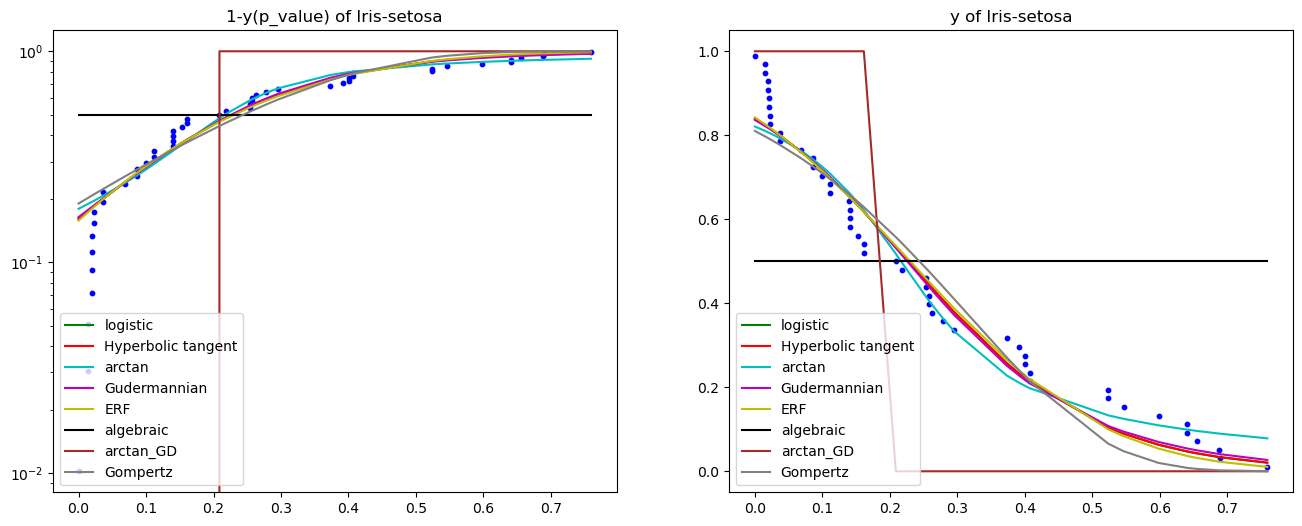

/tmp/ipykernel_2732296/590136884.py:328: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_2732296/590136884.py:329: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.0


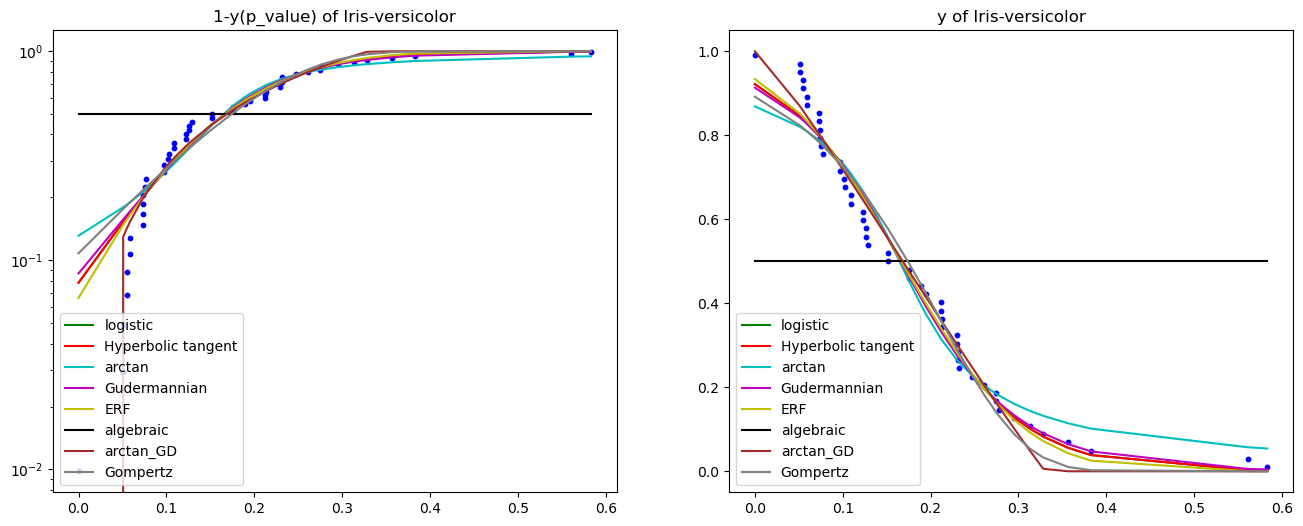

/tmp/ipykernel_2732296/590136884.py:328: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_2732296/590136884.py:329: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.01233217398687625


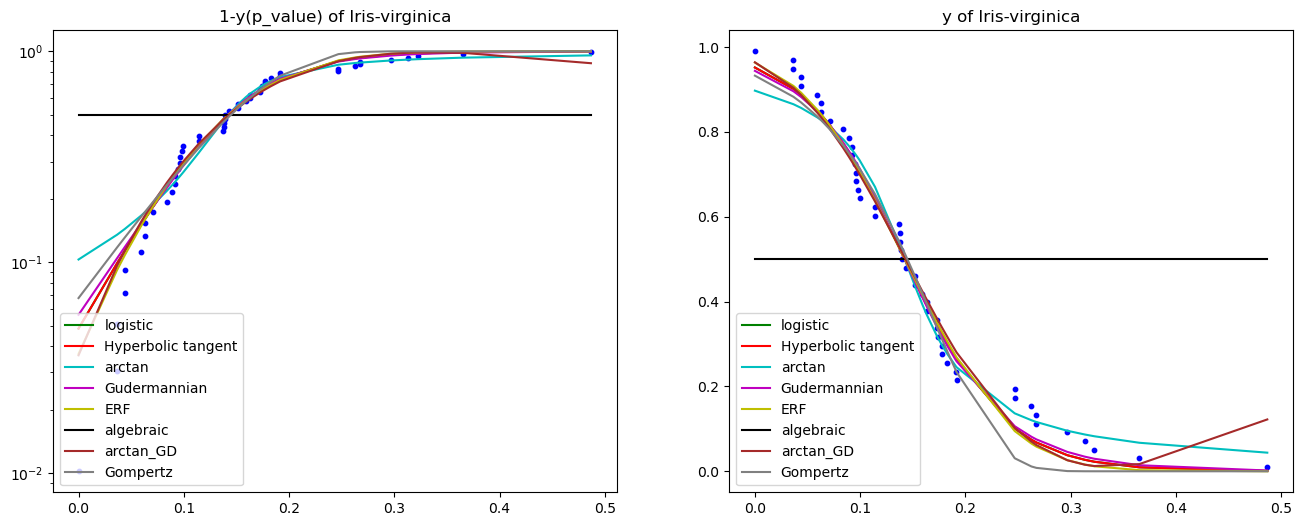

arctan
nearest NN[3.6715119501371656, 0.36055512754641234, 0.282842712474616]
sigmoid value[0.056614418499520536, 0.7986258864694584, 0.8549841180553583]
arctan
nearDis:  [3.6715119501371656, 0.36055512754641234, 0.282842712474616]
sigmoid Val:  [0.056614418499520536, 0.7986258864694584, 0.8549841180553583]


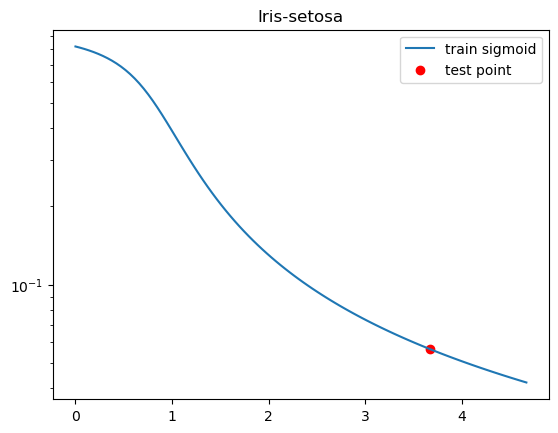

nearDis:  [3.6715119501371656, 0.36055512754641234, 0.282842712474616]
sigmoid Val:  [0.056614418499520536, 0.7986258864694584, 0.8549841180553583]


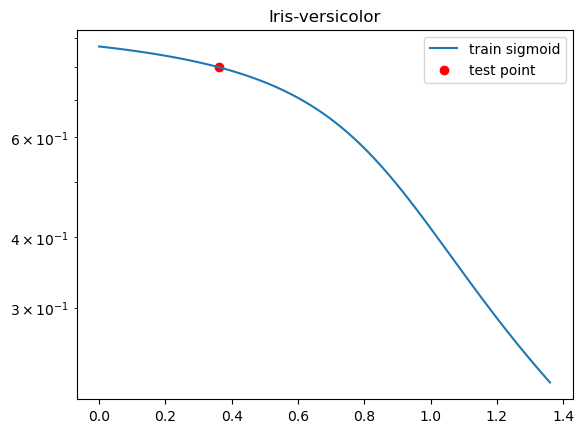

nearDis:  [3.6715119501371656, 0.36055512754641234, 0.282842712474616]
sigmoid Val:  [0.056614418499520536, 0.7986258864694584, 0.8549841180553583]


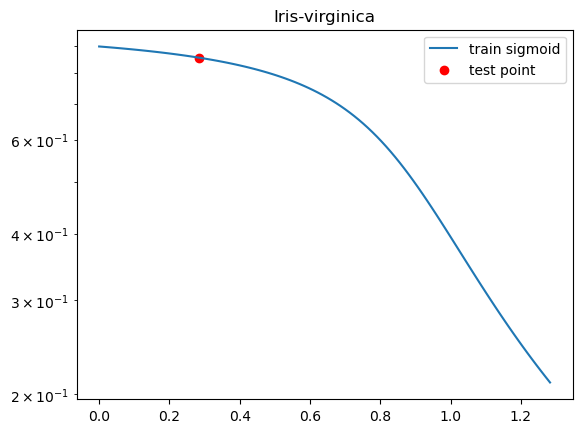

[0.056614418499520536, 0.7986258864694584, 0.8549841180553583]


In [19]:
print("--------Iris---------")
# data_lst = []
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
df_origin = pd.read_csv("../data/Iris/Iris-Original", header=None, sep=',')
df_oo = pd.read_csv("../data/Iris/Iris-test", header=None, sep=',')
last_col = df_origin.iloc[:, -1]

# Select all but the last column and move it to the first position
df_new = pd.concat([last_col, df_origin.iloc[:, :-1]], axis=1)
# print(df_new)
# print(df_new)
# print(df_new)
# test_SP = knn_distinguish(df_new, df_oo, classes)
test_SP = knn_distinguish(df_new.iloc[:-1, ], df_oo, classes)
print(test_SP.getPvalue())

In [3]:
print("-----------------test skin-----------------")
df_train = pd.read_csv("../data/Skin_NonSkin.csv", header=None, sep='\t')
class_skin = ['1', '2']
df_test = pd.read_csv("../data/skin_test.csv", header=None, sep=' ')
# print(df_test)
df_train.iloc[:, -1] = df_train.iloc[:, -1].astype(str)
last_col = df_train.iloc[:, -1]

# Select all but the last column and move it to the first position
df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)
# df_new[0] = df_new[0].astype(str)
print(df_new[0].dtypes)
# print(df_new)
# print(df_new)
# df_new[0] = df_new[0].astype(str)
test_skin = knn_distinguish(df_new, df_test, class_skin)
print(test_skin.getPvalue())

-----------------test skin-----------------
int64


KeyboardInterrupt: 

-----------------test heart-----------------


/tmp/ipykernel_2732296/590136884.py:328: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_2732296/590136884.py:329: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.04788060575530714


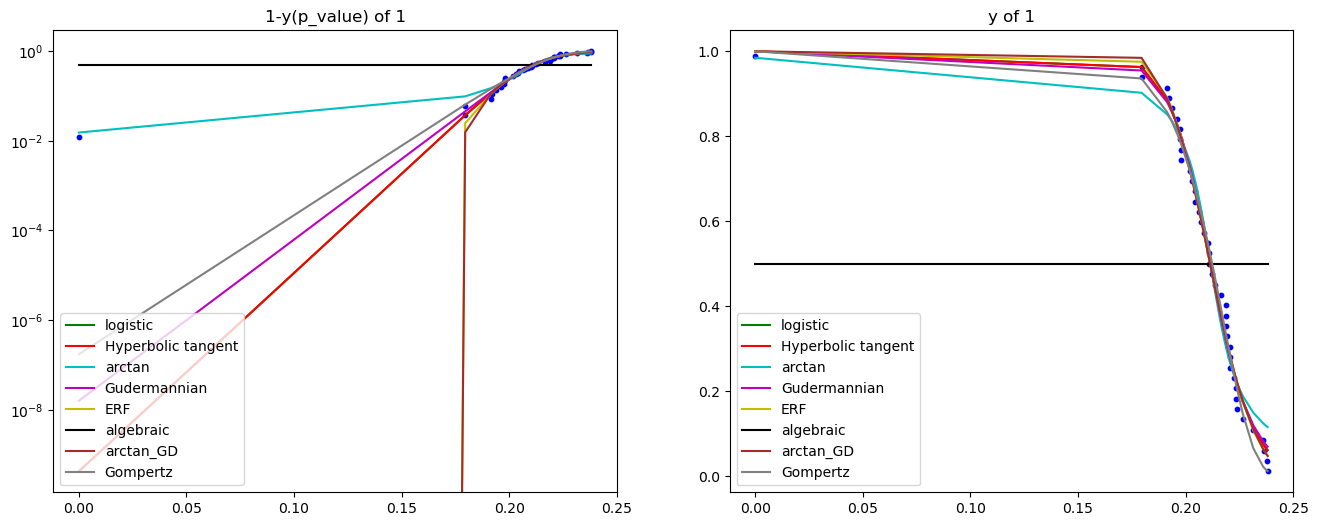

/tmp/ipykernel_2732296/590136884.py:328: RuntimeWarning: divide by zero encountered in power
  denominator = (1 + abs_x ** k) ** (1/k)
/tmp/ipykernel_2732296/590136884.py:329: RuntimeWarning: invalid value encountered in true_divide
  m = (1 + x / denominator) / 2
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.041482077049415235


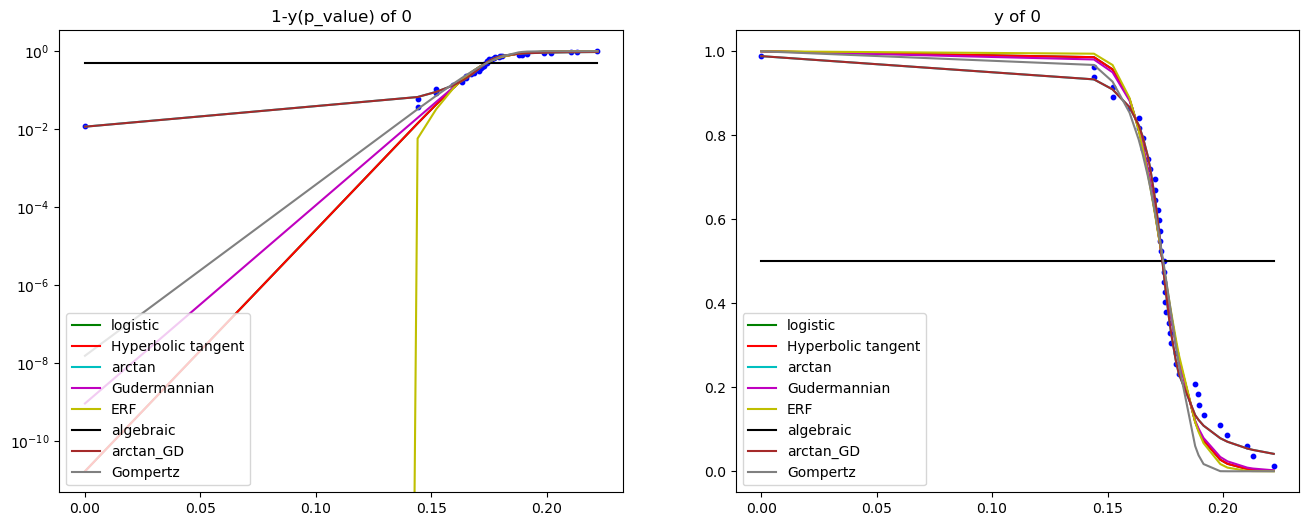

arctan_gd
nearest NN[50.813384063650005, 50.27922035990614]
sigmoid value[0.0, 0.00023172540825823249]
using arctan_GD
{'1': array([ 0.99834958, -6.93216942,  1.38308507]), '0': array([  0.98678372, -28.99461074,  -0.04044989])}
nearDis:  [50.813384063650005, 50.27922035990614]
sigmoid Val:  [0.0, 0.00023172540825823249]


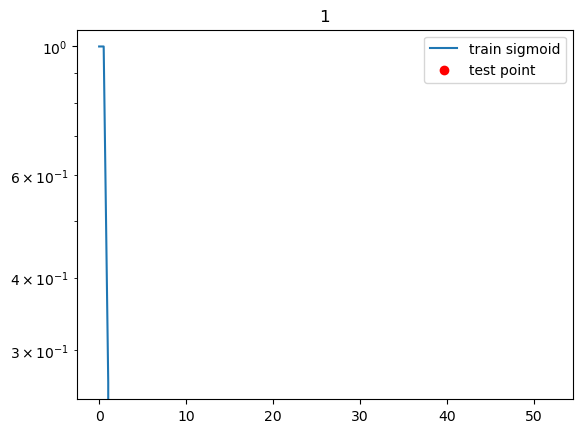

nearDis:  [50.813384063650005, 50.27922035990614]
sigmoid Val:  [0.0, 0.00023172540825823249]


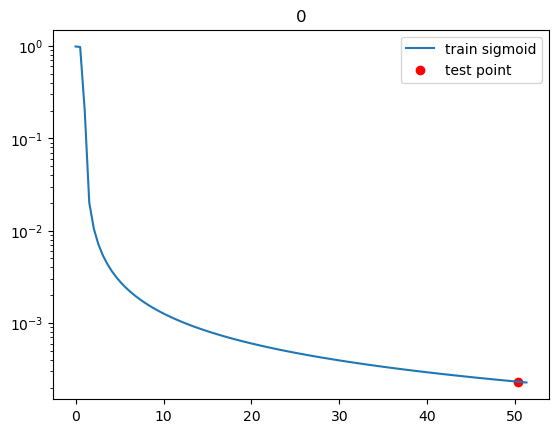

[0.0, 0.00023172540825823249]


In [28]:
print("-----------------test heart-----------------")
df_train = pd.read_csv("../data/SPECT/SPECTF.train", header=None, sep=',')
class_heart = ['1', '0']
df_test = pd.read_csv("../data/SPECT/SPECTF.test", header=None, sep=',')
df_test = df_test.iloc[:, 1:]
# print(df_test.shape)
df_test = df_test.iloc[[19]]
# print(df_test)
# print(df_test)
# last_col = df_train.iloc[:, -1]

# # Select all but the last column and move it to the first position
# df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)
df_train[0] = df_train[0].astype(str)
# print(df_train.shape)
# print(df_test.shape)
# df_new[0] = df_new[0].astype(str)
test_heart = knn_distinguish(df_train, df_test, class_heart)
print(test_heart.getPvalue())

In [ ]:
print("-----------------test spam-----------------")
df_train = pd.read_csv("../data/spambase/spambase.data", header=None, sep=',')
class_spam = ['1', '0']
df_test = pd.read_csv("../data/spambase/test.csv", header=None, sep=',')
# print(df_test.shape)
df_train.iloc[:, -1] = df_train.iloc[:, -1].astype(str)
last_col = df_train.iloc[:, -1]
# print(df_test.iloc[0].dtype)
# Select all but the last column and move it to the first position
df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)
# df_new[0] = df_new[0].astype(str)
test_spam = knn_distinguish(df_new, df_test, class_spam)
print(test_spam.getPvalue())

In [ ]:
print()

In [ ]:
print("------------------test--------------accelerator")
df_train = pd.read_csv("../data/accelerator/accelerometer.csv", header=None, sep=',', skiprows=1)
class_acc = ['1', '2', '3']
df_train[0] = df_train[0].astype(str)
df_test = pd.read_csv("../data/accelerator/test.csv", header=None, sep=',')
test_acc = knn_distinguish(df_train, df_test, class_acc)
print(test_acc.getPvalue())

In [ ]:
print("--------process Arcene-------")
df_test = pd.read_csv("../data/Arcene/arcene_test.data", header=None, sep=' ')
average = df_test.mean().values[0]
df_test['New_Column'] = average

# Save the updated DataFrame to the CSV file
df_test.to_csv('../data/Arcene/test_file.csv', index=False)

In [ ]:
print("------------test Arcene------------")
df_arcene_train = pd.read_csv("../data/Arcene/arcene_train.data", header=None, sep=' ')
print(df_train.shape)
df_arcene_label = pd.read_csv("..data/Arcene/arcene_train.labels", header=None, sep=' ')
df_arcene_test = pd.read_csv("../data/Arcene/arcene_test.data", header=None, sep=' ')
print(df_test.shape)
nan_columns = df_arcene_test.columns[df_arcene_test.isna().any()].tolist()

# Delete the columns that contain NaN values
df_arcene_test = df_arcene_test.drop(nan_columns, axis=1)

#print(df_arcene_test)



classes = list(map(str, df_arcene_label[0].unique()))

df_new_arcene_train = preprocess(df_arcene_train, None, None, df_arcene_label)
nan_columns = df_new_arcene_train.columns[df_new_arcene_train.isna().any()].tolist()

# Delete the columns that contain NaN values
df_new_arcene_train = df_new_arcene_train.drop(nan_columns, axis=1)

#print(df_new_arcene_train)
#print(df_new_arcene_train)
#print(df_new_arcene_train.shape)
df_train.iloc[:, -1] = df_train.iloc[:, -1].astype(str)
last_col = df_train.iloc[:, -1]
df_test = df_test.iloc[:, :-1]
print(df_test)
#print(df_arcene_test)
#print(df_arcene_test.iloc[0].shape)
print(df_test.shape)
df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)
knn_arcene = knn_distinguish(df_new_arcene_train, classes)
knn_arcene_fit = knn_arcene.fit()
print(knn_arcene.predict(df_arcene_test.iloc[[48]], knn_arcene_fit[0], knn_arcene_fit[1]))

In [ ]:
print("test audit")
df_train = pd.read_csv("../data/audit_data/audit_risk.csv", header=None, sep=',')
location = df_train.loc[df_train.eq('LOHARU').any(axis=1), df_train.columns[df_new.eq('LOHARU').any()]].values.tolist()[0]
print(f"'LOHARU' is located at row {location[0]} and column {location[1]}.")
df_train.iloc[:, -1] = df_train.iloc[:, -1].astype(str)
last_col = df_train.iloc[:, -1]
# print(df_test.iloc[0].dtype)
search_string = 'LOHARU'
df_new = pd.concat([last_col, df_train.iloc[:, :-1]], axis=1)

if df_new.isin([search_string]).any().any():
    print(f'The string "{search_string}" was found in the dataset.')
else:
    print(f'The string "{search_string}" was not found in the dataset.')
class_audit = ['1', '0']
df_test = pd.read_csv("../data/audit_data/test.csv")
test_audit = knn_distinguish(df_new, df_test, class_audit)
print(test_audit.getPvalue())

test audit


IndexError: list index out of range